In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

In [2]:
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

In [3]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [4]:
# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

60000

In [5]:

test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)
len(test_data)

10000

In [6]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [7]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [8]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.

        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [9]:
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 1,149,972


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [10]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [11]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [12]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [13]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 543.6483 (Recon: 543.4820, KL: 0.1663) Grad: 13.2188
Step 100 (N samples: 12,800), Loss: 186.3741 (Recon: 184.5418, KL: 1.8323) Grad: 24.4854
Step 200 (N samples: 25,600), Loss: 183.4187 (Recon: 181.1068, KL: 2.3119) Grad: 11.6981
Step 300 (N samples: 38,400), Loss: 176.1134 (Recon: 173.7852, KL: 2.3281) Grad: 30.3508
Step 400 (N samples: 51,200), Loss: 176.7013 (Recon: 172.5607, KL: 4.1406) Grad: 36.3255


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8323 (BCE: 165.3007, KLD: 4.5315)
Epoch 2/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 500 (N samples: 64,000), Loss: 171.0332 (Recon: 166.4832, KL: 4.5500) Grad: 58.0120
Step 600 (N samples: 76,800), Loss: 166.7722 (Recon: 162.1496, KL: 4.6226) Grad: 60.3045
Step 700 (N samples: 89,600), Loss: 159.8255 (Recon: 154.5374, KL: 5.2882) Grad: 76.0279
Step 800 (N samples: 102,400), Loss: 166.7115 (Recon: 161.5338, KL: 5.1777) Grad: 47.6451
Step 900 (N samples: 115,200), Loss: 152.5492 (Recon: 147.2328, KL: 5.3164) Grad: 44.1373


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 156.2586 (BCE: 150.9028, KLD: 5.3558)
Epoch 3/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,000 (N samples: 128,000), Loss: 161.1606 (Recon: 155.6479, KL: 5.5128) Grad: 78.0923
Step 1,100 (N samples: 140,800), Loss: 152.7392 (Recon: 147.4556, KL: 5.2836) Grad: 52.0360
Step 1,200 (N samples: 153,600), Loss: 153.6629 (Recon: 148.0884, KL: 5.5744) Grad: 68.9539
Step 1,300 (N samples: 166,400), Loss: 146.3198 (Recon: 140.7840, KL: 5.5359) Grad: 51.1859
Step 1,400 (N samples: 179,200), Loss: 151.9171 (Recon: 146.5526, KL: 5.3645) Grad: 52.7376


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 152.2894 (BCE: 146.5600, KLD: 5.7294)
Epoch 4/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,500 (N samples: 192,000), Loss: 151.4357 (Recon: 145.5128, KL: 5.9229) Grad: 83.3965
Step 1,600 (N samples: 204,800), Loss: 142.3177 (Recon: 136.4746, KL: 5.8431) Grad: 60.6562
Step 1,700 (N samples: 217,600), Loss: 156.3175 (Recon: 150.5092, KL: 5.8083) Grad: 56.3705
Step 1,800 (N samples: 230,400), Loss: 147.4852 (Recon: 141.4148, KL: 6.0704) Grad: 125.8632


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 149.3020 (BCE: 143.3030, KLD: 5.9991)
Epoch 5/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,900 (N samples: 243,200), Loss: 146.7695 (Recon: 140.8362, KL: 5.9333) Grad: 99.0728
Step 2,000 (N samples: 256,000), Loss: 152.8254 (Recon: 146.8618, KL: 5.9635) Grad: 79.3632
Step 2,100 (N samples: 268,800), Loss: 139.0305 (Recon: 133.0911, KL: 5.9394) Grad: 108.9871
Step 2,200 (N samples: 281,600), Loss: 146.1694 (Recon: 140.2037, KL: 5.9657) Grad: 92.0408
Step 2,300 (N samples: 294,400), Loss: 151.1652 (Recon: 145.0918, KL: 6.0735) Grad: 126.1277


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.4998 (BCE: 140.4444, KLD: 6.0554)
Epoch 6/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,400 (N samples: 307,200), Loss: 148.9662 (Recon: 142.9377, KL: 6.0284) Grad: 90.5431
Step 2,500 (N samples: 320,000), Loss: 140.8396 (Recon: 134.4673, KL: 6.3723) Grad: 87.4489
Step 2,600 (N samples: 332,800), Loss: 156.1897 (Recon: 150.2708, KL: 5.9190) Grad: 150.7559
Step 2,700 (N samples: 345,600), Loss: 153.7667 (Recon: 147.7709, KL: 5.9958) Grad: 141.8137
Step 2,800 (N samples: 358,400), Loss: 147.1678 (Recon: 140.9649, KL: 6.2029) Grad: 56.1106


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 147.7123 (BCE: 141.3253, KLD: 6.3870)
Epoch 7/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,900 (N samples: 371,200), Loss: 148.5853 (Recon: 142.2482, KL: 6.3370) Grad: 100.7322
Step 3,000 (N samples: 384,000), Loss: 152.9107 (Recon: 146.7228, KL: 6.1879) Grad: 140.3137
Step 3,100 (N samples: 396,800), Loss: 141.5608 (Recon: 135.2681, KL: 6.2927) Grad: 106.7438
Step 3,200 (N samples: 409,600), Loss: 151.9651 (Recon: 145.7657, KL: 6.1993) Grad: 109.4241


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 145.8180 (BCE: 139.4090, KLD: 6.4090)
Epoch 8/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,300 (N samples: 422,400), Loss: 135.1118 (Recon: 128.8944, KL: 6.2174) Grad: 115.3696
Step 3,400 (N samples: 435,200), Loss: 140.5292 (Recon: 134.3831, KL: 6.1461) Grad: 163.2539
Step 3,500 (N samples: 448,000), Loss: 140.6670 (Recon: 134.3253, KL: 6.3417) Grad: 114.8094
Step 3,600 (N samples: 460,800), Loss: 143.4219 (Recon: 136.9416, KL: 6.4803) Grad: 130.6088
Step 3,700 (N samples: 473,600), Loss: 142.0464 (Recon: 135.6578, KL: 6.3886) Grad: 115.3786


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.1597 (BCE: 137.7718, KLD: 6.3879)
Epoch 9/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,800 (N samples: 486,400), Loss: 139.3988 (Recon: 133.0380, KL: 6.3608) Grad: 156.1911
Step 3,900 (N samples: 499,200), Loss: 137.9317 (Recon: 131.5847, KL: 6.3470) Grad: 86.7649
Step 4,000 (N samples: 512,000), Loss: 142.4600 (Recon: 136.1471, KL: 6.3129) Grad: 204.3891
Step 4,100 (N samples: 524,800), Loss: 149.0525 (Recon: 142.6097, KL: 6.4428) Grad: 91.0996
Step 4,200 (N samples: 537,600), Loss: 146.1004 (Recon: 139.7480, KL: 6.3524) Grad: 74.8207


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.3101 (BCE: 137.8011, KLD: 6.5090)
Epoch 10/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,300 (N samples: 550,400), Loss: 143.7741 (Recon: 137.1523, KL: 6.6219) Grad: 73.7099
Step 4,400 (N samples: 563,200), Loss: 144.2435 (Recon: 137.9088, KL: 6.3347) Grad: 90.3901
Step 4,500 (N samples: 576,000), Loss: 145.0199 (Recon: 138.6719, KL: 6.3480) Grad: 57.1874
Step 4,600 (N samples: 588,800), Loss: 143.0105 (Recon: 136.3312, KL: 6.6793) Grad: 180.6295


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.3697 (BCE: 136.9788, KLD: 6.3909)
Epoch 11/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,700 (N samples: 601,600), Loss: 144.4197 (Recon: 138.0542, KL: 6.3655) Grad: 64.0137
Step 4,800 (N samples: 614,400), Loss: 148.0497 (Recon: 141.6085, KL: 6.4412) Grad: 165.2326
Step 4,900 (N samples: 627,200), Loss: 149.2025 (Recon: 142.8133, KL: 6.3892) Grad: 203.2082
Step 5,000 (N samples: 640,000), Loss: 134.2138 (Recon: 127.7319, KL: 6.4820) Grad: 105.8877
Step 5,100 (N samples: 652,800), Loss: 142.1086 (Recon: 135.5741, KL: 6.5345) Grad: 191.3377


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.1914 (BCE: 137.5497, KLD: 6.6416)
Epoch 12/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5,200 (N samples: 665,600), Loss: 141.4906 (Recon: 135.0468, KL: 6.4438) Grad: 82.0045
Step 5,300 (N samples: 678,400), Loss: 150.3842 (Recon: 143.9359, KL: 6.4483) Grad: 117.8209
Step 5,400 (N samples: 691,200), Loss: 144.7620 (Recon: 138.1959, KL: 6.5661) Grad: 112.6509
Step 5,500 (N samples: 704,000), Loss: 144.4724 (Recon: 138.0308, KL: 6.4416) Grad: 76.4684
Step 5,600 (N samples: 716,800), Loss: 142.3304 (Recon: 135.6402, KL: 6.6902) Grad: 110.6796


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.5298 (BCE: 134.9109, KLD: 6.6189)
Epoch 13/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5,700 (N samples: 729,600), Loss: 138.7258 (Recon: 132.2061, KL: 6.5196) Grad: 81.8579
Step 5,800 (N samples: 742,400), Loss: 137.7918 (Recon: 131.0473, KL: 6.7445) Grad: 126.9998
Step 5,900 (N samples: 755,200), Loss: 139.1572 (Recon: 132.5192, KL: 6.6380) Grad: 92.1287
Step 6,000 (N samples: 768,000), Loss: 147.7327 (Recon: 141.3663, KL: 6.3664) Grad: 197.3168


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.0974 (BCE: 136.6026, KLD: 6.4948)
Epoch 14/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6,100 (N samples: 780,800), Loss: 145.7374 (Recon: 139.0341, KL: 6.7034) Grad: 127.6023
Step 6,200 (N samples: 793,600), Loss: 141.6527 (Recon: 135.2032, KL: 6.4495) Grad: 102.8920
Step 6,300 (N samples: 806,400), Loss: 137.2694 (Recon: 130.6087, KL: 6.6607) Grad: 142.2895
Step 6,400 (N samples: 819,200), Loss: 147.6222 (Recon: 141.1086, KL: 6.5136) Grad: 152.1675
Step 6,500 (N samples: 832,000), Loss: 139.5912 (Recon: 133.0249, KL: 6.5663) Grad: 94.3195


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.2235 (BCE: 135.5481, KLD: 6.6754)
Epoch 15/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6,600 (N samples: 844,800), Loss: 139.6605 (Recon: 132.9073, KL: 6.7532) Grad: 215.4804
Step 6,700 (N samples: 857,600), Loss: 142.8286 (Recon: 135.9299, KL: 6.8986) Grad: 129.4531
Step 6,800 (N samples: 870,400), Loss: 148.5256 (Recon: 142.0100, KL: 6.5155) Grad: 144.1505
Step 6,900 (N samples: 883,200), Loss: 136.2276 (Recon: 129.4466, KL: 6.7811) Grad: 130.7651
Step 7,000 (N samples: 896,000), Loss: 135.2534 (Recon: 128.5861, KL: 6.6674) Grad: 249.3019


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.6802 (BCE: 135.0522, KLD: 6.6280)
Epoch 16/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7,100 (N samples: 908,800), Loss: 140.4543 (Recon: 133.7029, KL: 6.7514) Grad: 92.9669
Step 7,200 (N samples: 921,600), Loss: 147.6970 (Recon: 141.0640, KL: 6.6330) Grad: 154.2440
Step 7,300 (N samples: 934,400), Loss: 135.2162 (Recon: 128.5551, KL: 6.6611) Grad: 172.1572
Step 7,400 (N samples: 947,200), Loss: 140.0168 (Recon: 133.4853, KL: 6.5315) Grad: 85.7808
Step 7,500 (N samples: 960,000), Loss: 140.3576 (Recon: 133.5864, KL: 6.7713) Grad: 154.5880


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.8403 (BCE: 135.0787, KLD: 6.7616)
Epoch 17/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7,600 (N samples: 972,800), Loss: 138.9520 (Recon: 132.3790, KL: 6.5730) Grad: 199.7703
Step 7,700 (N samples: 985,600), Loss: 139.5259 (Recon: 132.9084, KL: 6.6175) Grad: 100.5569
Step 7,800 (N samples: 998,400), Loss: 136.7266 (Recon: 130.0089, KL: 6.7177) Grad: 107.7535
Step 7,900 (N samples: 1,011,200), Loss: 136.7620 (Recon: 130.2204, KL: 6.5416) Grad: 94.1732


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.0036 (BCE: 134.3304, KLD: 6.6732)
Epoch 18/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8,000 (N samples: 1,024,000), Loss: 142.2507 (Recon: 135.4982, KL: 6.7526) Grad: 236.4137
Step 8,100 (N samples: 1,036,800), Loss: 148.0153 (Recon: 141.3947, KL: 6.6206) Grad: 299.5753
Step 8,200 (N samples: 1,049,600), Loss: 150.4011 (Recon: 143.6647, KL: 6.7363) Grad: 221.3209
Step 8,300 (N samples: 1,062,400), Loss: 141.8095 (Recon: 135.2287, KL: 6.5808) Grad: 137.3839
Step 8,400 (N samples: 1,075,200), Loss: 139.5272 (Recon: 132.8404, KL: 6.6868) Grad: 147.0639


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.1873 (BCE: 136.7284, KLD: 6.4588)
Epoch 19/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8,500 (N samples: 1,088,000), Loss: 140.9632 (Recon: 134.1239, KL: 6.8393) Grad: 230.3117
Step 8,600 (N samples: 1,100,800), Loss: 141.0243 (Recon: 134.5567, KL: 6.4676) Grad: 114.3381
Step 8,700 (N samples: 1,113,600), Loss: 137.9376 (Recon: 131.3065, KL: 6.6311) Grad: 140.8971
Step 8,800 (N samples: 1,126,400), Loss: 145.5986 (Recon: 138.8396, KL: 6.7590) Grad: 417.6266
Step 8,900 (N samples: 1,139,200), Loss: 139.5792 (Recon: 132.6886, KL: 6.8906) Grad: 222.9050


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.5087 (BCE: 134.8423, KLD: 6.6665)
Epoch 20/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,000 (N samples: 1,152,000), Loss: 133.0774 (Recon: 126.1631, KL: 6.9143) Grad: 202.0122
Step 9,100 (N samples: 1,164,800), Loss: 142.6191 (Recon: 135.9718, KL: 6.6473) Grad: 224.4589
Step 9,200 (N samples: 1,177,600), Loss: 140.1039 (Recon: 133.5762, KL: 6.5277) Grad: 333.6349
Step 9,300 (N samples: 1,190,400), Loss: 144.7138 (Recon: 138.0659, KL: 6.6479) Grad: 289.4714


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.7349 (BCE: 135.0936, KLD: 6.6413)
Epoch 21/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,400 (N samples: 1,203,200), Loss: 144.2120 (Recon: 137.4495, KL: 6.7625) Grad: 234.8346
Step 9,500 (N samples: 1,216,000), Loss: 133.6969 (Recon: 127.0451, KL: 6.6518) Grad: 155.8946
Step 9,600 (N samples: 1,228,800), Loss: 138.9500 (Recon: 132.3087, KL: 6.6413) Grad: 137.1015
Step 9,700 (N samples: 1,241,600), Loss: 140.6382 (Recon: 133.9018, KL: 6.7364) Grad: 168.5814
Step 9,800 (N samples: 1,254,400), Loss: 136.4550 (Recon: 129.4003, KL: 7.0546) Grad: 107.8710


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.5656 (BCE: 133.8370, KLD: 6.7286)
Epoch 22/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,900 (N samples: 1,267,200), Loss: 140.4000 (Recon: 133.4745, KL: 6.9255) Grad: 128.9091
Step 10,000 (N samples: 1,280,000), Loss: 140.7081 (Recon: 133.7728, KL: 6.9353) Grad: 210.3091
Step 10,100 (N samples: 1,292,800), Loss: 143.9577 (Recon: 137.2176, KL: 6.7401) Grad: 153.6288
Step 10,200 (N samples: 1,305,600), Loss: 138.0020 (Recon: 131.1596, KL: 6.8424) Grad: 195.2846
Step 10,300 (N samples: 1,318,400), Loss: 137.9105 (Recon: 131.3063, KL: 6.6042) Grad: 86.8065


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.7608 (BCE: 135.8921, KLD: 6.8687)
Epoch 23/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10,400 (N samples: 1,331,200), Loss: 135.1471 (Recon: 128.6676, KL: 6.4795) Grad: 161.6142
Step 10,500 (N samples: 1,344,000), Loss: 148.3334 (Recon: 141.5800, KL: 6.7533) Grad: 194.9180
Step 10,600 (N samples: 1,356,800), Loss: 144.3979 (Recon: 137.5919, KL: 6.8060) Grad: 232.7649
Step 10,700 (N samples: 1,369,600), Loss: 145.0691 (Recon: 138.3004, KL: 6.7687) Grad: 122.4524


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.1201 (BCE: 136.4012, KLD: 6.7190)
Epoch 24/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10,800 (N samples: 1,382,400), Loss: 139.3116 (Recon: 132.3626, KL: 6.9490) Grad: 154.0394
Step 10,900 (N samples: 1,395,200), Loss: 141.0921 (Recon: 134.2464, KL: 6.8457) Grad: 165.8068
Step 11,000 (N samples: 1,408,000), Loss: 143.9678 (Recon: 137.0014, KL: 6.9664) Grad: 164.4964
Step 11,100 (N samples: 1,420,800), Loss: 147.4951 (Recon: 140.7044, KL: 6.7907) Grad: 210.0513
Step 11,200 (N samples: 1,433,600), Loss: 138.6744 (Recon: 131.8499, KL: 6.8245) Grad: 278.9481


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.6461 (BCE: 133.9427, KLD: 6.7035)
Epoch 25/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11,300 (N samples: 1,446,400), Loss: 132.6379 (Recon: 125.6844, KL: 6.9535) Grad: 177.7284
Step 11,400 (N samples: 1,459,200), Loss: 136.0888 (Recon: 129.2459, KL: 6.8429) Grad: 192.6907
Step 11,500 (N samples: 1,472,000), Loss: 141.9587 (Recon: 135.1861, KL: 6.7726) Grad: 188.7238
Step 11,600 (N samples: 1,484,800), Loss: 146.3822 (Recon: 139.7250, KL: 6.6573) Grad: 173.2686
Step 11,700 (N samples: 1,497,600), Loss: 141.6948 (Recon: 134.8193, KL: 6.8755) Grad: 222.2147


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.1446 (BCE: 132.3893, KLD: 6.7553)
Epoch 26/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11,800 (N samples: 1,510,400), Loss: 138.0523 (Recon: 131.0905, KL: 6.9619) Grad: 133.6411
Step 11,900 (N samples: 1,523,200), Loss: 137.8590 (Recon: 130.9609, KL: 6.8981) Grad: 216.8175
Step 12,000 (N samples: 1,536,000), Loss: 143.0796 (Recon: 136.3222, KL: 6.7573) Grad: 185.5818
Step 12,100 (N samples: 1,548,800), Loss: 138.2729 (Recon: 131.3838, KL: 6.8892) Grad: 222.4354


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.1220 (BCE: 133.3180, KLD: 6.8041)
Epoch 27/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12,200 (N samples: 1,561,600), Loss: 137.9178 (Recon: 131.0432, KL: 6.8746) Grad: 182.6314
Step 12,300 (N samples: 1,574,400), Loss: 142.7408 (Recon: 135.8367, KL: 6.9041) Grad: 143.3418
Step 12,400 (N samples: 1,587,200), Loss: 132.1152 (Recon: 125.1168, KL: 6.9984) Grad: 98.4869
Step 12,500 (N samples: 1,600,000), Loss: 138.5049 (Recon: 131.6954, KL: 6.8095) Grad: 132.5409
Step 12,600 (N samples: 1,612,800), Loss: 152.7265 (Recon: 146.2693, KL: 6.4572) Grad: 129.4263


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.9018 (BCE: 132.0853, KLD: 6.8165)
Epoch 28/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12,700 (N samples: 1,625,600), Loss: 138.7398 (Recon: 131.7680, KL: 6.9717) Grad: 173.8888
Step 12,800 (N samples: 1,638,400), Loss: 132.6943 (Recon: 125.6497, KL: 7.0446) Grad: 128.7567
Step 12,900 (N samples: 1,651,200), Loss: 133.9810 (Recon: 127.2334, KL: 6.7477) Grad: 167.6721
Step 13,000 (N samples: 1,664,000), Loss: 139.5206 (Recon: 132.7830, KL: 6.7377) Grad: 139.4008
Step 13,100 (N samples: 1,676,800), Loss: 148.4594 (Recon: 141.7064, KL: 6.7529) Grad: 158.5585


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.1702 (BCE: 134.2814, KLD: 6.8888)
Epoch 29/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13,200 (N samples: 1,689,600), Loss: 143.0883 (Recon: 136.1988, KL: 6.8896) Grad: 187.7840
Step 13,300 (N samples: 1,702,400), Loss: 140.1775 (Recon: 133.1968, KL: 6.9806) Grad: 244.0522
Step 13,400 (N samples: 1,715,200), Loss: 137.2259 (Recon: 130.4593, KL: 6.7666) Grad: 148.1013
Step 13,500 (N samples: 1,728,000), Loss: 151.3661 (Recon: 144.4229, KL: 6.9432) Grad: 445.6504
Step 13,600 (N samples: 1,740,800), Loss: 137.5446 (Recon: 130.6417, KL: 6.9029) Grad: 183.3794


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.5977 (BCE: 132.8265, KLD: 6.7712)
Epoch 30/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13,700 (N samples: 1,753,600), Loss: 144.9330 (Recon: 138.2023, KL: 6.7307) Grad: 164.3043
Step 13,800 (N samples: 1,766,400), Loss: 140.6034 (Recon: 133.6418, KL: 6.9616) Grad: 221.6360
Step 13,900 (N samples: 1,779,200), Loss: 139.3148 (Recon: 132.5066, KL: 6.8082) Grad: 202.2252
Step 14,000 (N samples: 1,792,000), Loss: 140.8280 (Recon: 133.8641, KL: 6.9639) Grad: 115.3288


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.1212 (BCE: 132.1331, KLD: 6.9882)
Epoch 31/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14,100 (N samples: 1,804,800), Loss: 135.7843 (Recon: 128.7584, KL: 7.0259) Grad: 253.7507
Step 14,200 (N samples: 1,817,600), Loss: 136.3734 (Recon: 129.5873, KL: 6.7861) Grad: 224.1057
Step 14,300 (N samples: 1,830,400), Loss: 135.6193 (Recon: 128.8570, KL: 6.7624) Grad: 205.2730
Step 14,400 (N samples: 1,843,200), Loss: 142.4135 (Recon: 135.5872, KL: 6.8263) Grad: 136.1993
Step 14,500 (N samples: 1,856,000), Loss: 136.7495 (Recon: 129.8056, KL: 6.9440) Grad: 193.6102


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.1308 (BCE: 132.1696, KLD: 6.9611)
Epoch 32/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14,600 (N samples: 1,868,800), Loss: 137.9678 (Recon: 130.9841, KL: 6.9836) Grad: 153.0502
Step 14,700 (N samples: 1,881,600), Loss: 131.7272 (Recon: 124.5811, KL: 7.1461) Grad: 157.4814
Step 14,800 (N samples: 1,894,400), Loss: 139.1173 (Recon: 132.0862, KL: 7.0311) Grad: 125.5501
Step 14,900 (N samples: 1,907,200), Loss: 145.6286 (Recon: 138.8320, KL: 6.7966) Grad: 169.9443
Step 15,000 (N samples: 1,920,000), Loss: 141.6167 (Recon: 134.8662, KL: 6.7504) Grad: 180.9183


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.3701 (BCE: 133.5694, KLD: 6.8008)
Epoch 33/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15,100 (N samples: 1,932,800), Loss: 140.2314 (Recon: 133.3144, KL: 6.9170) Grad: 129.9855
Step 15,200 (N samples: 1,945,600), Loss: 129.9712 (Recon: 122.9669, KL: 7.0043) Grad: 173.4684
Step 15,300 (N samples: 1,958,400), Loss: 142.7711 (Recon: 135.9951, KL: 6.7760) Grad: 290.0758
Step 15,400 (N samples: 1,971,200), Loss: 134.4214 (Recon: 127.4056, KL: 7.0159) Grad: 292.0086


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.0649 (BCE: 132.1779, KLD: 6.8870)
Epoch 34/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15,500 (N samples: 1,984,000), Loss: 141.2879 (Recon: 134.2383, KL: 7.0497) Grad: 142.3941
Step 15,600 (N samples: 1,996,800), Loss: 139.1589 (Recon: 132.5474, KL: 6.6115) Grad: 161.0765
Step 15,700 (N samples: 2,009,600), Loss: 137.9120 (Recon: 131.0287, KL: 6.8833) Grad: 272.2241
Step 15,800 (N samples: 2,022,400), Loss: 140.3739 (Recon: 133.4700, KL: 6.9039) Grad: 181.0802
Step 15,900 (N samples: 2,035,200), Loss: 139.0695 (Recon: 132.3102, KL: 6.7593) Grad: 124.0641


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.7823 (BCE: 131.9189, KLD: 6.8635)
Epoch 35/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16,000 (N samples: 2,048,000), Loss: 136.6344 (Recon: 129.4942, KL: 7.1401) Grad: 151.2647
Step 16,100 (N samples: 2,060,800), Loss: 137.8632 (Recon: 131.0263, KL: 6.8369) Grad: 161.2270
Step 16,200 (N samples: 2,073,600), Loss: 135.8145 (Recon: 128.9703, KL: 6.8442) Grad: 190.8249
Step 16,300 (N samples: 2,086,400), Loss: 144.5781 (Recon: 137.6369, KL: 6.9412) Grad: 150.4037
Step 16,400 (N samples: 2,099,200), Loss: 139.2262 (Recon: 132.4204, KL: 6.8058) Grad: 162.7284


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.0716 (BCE: 135.1389, KLD: 6.9326)
Epoch 36/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16,500 (N samples: 2,112,000), Loss: 135.6707 (Recon: 128.7704, KL: 6.9003) Grad: 191.5507
Step 16,600 (N samples: 2,124,800), Loss: 144.7944 (Recon: 137.7329, KL: 7.0615) Grad: 221.0404
Step 16,700 (N samples: 2,137,600), Loss: 140.3764 (Recon: 133.4838, KL: 6.8926) Grad: 244.4754
Step 16,800 (N samples: 2,150,400), Loss: 140.2790 (Recon: 133.2532, KL: 7.0258) Grad: 193.1051


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.8881 (BCE: 133.0158, KLD: 6.8723)
Epoch 37/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16,900 (N samples: 2,163,200), Loss: 137.0083 (Recon: 129.9551, KL: 7.0532) Grad: 297.1329
Step 17,000 (N samples: 2,176,000), Loss: 139.6527 (Recon: 132.5732, KL: 7.0795) Grad: 163.5087
Step 17,100 (N samples: 2,188,800), Loss: 139.9877 (Recon: 133.1133, KL: 6.8744) Grad: 181.2389
Step 17,200 (N samples: 2,201,600), Loss: 143.2548 (Recon: 136.4375, KL: 6.8172) Grad: 205.1665
Step 17,300 (N samples: 2,214,400), Loss: 138.0057 (Recon: 131.1732, KL: 6.8325) Grad: 301.0890


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.5752 (BCE: 131.6042, KLD: 6.9710)
Epoch 38/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17,400 (N samples: 2,227,200), Loss: 144.1372 (Recon: 137.0204, KL: 7.1169) Grad: 206.1942
Step 17,500 (N samples: 2,240,000), Loss: 148.6056 (Recon: 141.4724, KL: 7.1332) Grad: 182.6704
Step 17,600 (N samples: 2,252,800), Loss: 137.4461 (Recon: 130.3804, KL: 7.0657) Grad: 177.6006
Step 17,700 (N samples: 2,265,600), Loss: 145.0603 (Recon: 138.1201, KL: 6.9402) Grad: 261.5391
Step 17,800 (N samples: 2,278,400), Loss: 131.6288 (Recon: 124.6478, KL: 6.9810) Grad: 256.6345


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.7147 (BCE: 131.6158, KLD: 7.0989)
Epoch 39/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17,900 (N samples: 2,291,200), Loss: 136.4739 (Recon: 129.3519, KL: 7.1221) Grad: 162.6732
Step 18,000 (N samples: 2,304,000), Loss: 137.7915 (Recon: 130.8107, KL: 6.9809) Grad: 244.2986
Step 18,100 (N samples: 2,316,800), Loss: 131.2939 (Recon: 124.5954, KL: 6.6985) Grad: 198.3450
Step 18,200 (N samples: 2,329,600), Loss: 140.6273 (Recon: 133.6004, KL: 7.0269) Grad: 268.6578


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.1382 (BCE: 132.1008, KLD: 7.0373)
Epoch 40/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18,300 (N samples: 2,342,400), Loss: 146.6451 (Recon: 139.4935, KL: 7.1515) Grad: 188.8714
Step 18,400 (N samples: 2,355,200), Loss: 141.5388 (Recon: 134.5852, KL: 6.9537) Grad: 261.8035
Step 18,500 (N samples: 2,368,000), Loss: 136.3330 (Recon: 129.3398, KL: 6.9932) Grad: 241.9770
Step 18,600 (N samples: 2,380,800), Loss: 135.9817 (Recon: 129.0835, KL: 6.8982) Grad: 141.4593
Step 18,700 (N samples: 2,393,600), Loss: 137.0868 (Recon: 130.3548, KL: 6.7321) Grad: 192.1873


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.6331 (BCE: 132.6244, KLD: 7.0087)
Epoch 41/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18,800 (N samples: 2,406,400), Loss: 146.3475 (Recon: 139.5323, KL: 6.8152) Grad: 182.2576
Step 18,900 (N samples: 2,419,200), Loss: 133.8522 (Recon: 126.6173, KL: 7.2349) Grad: 224.9675
Step 19,000 (N samples: 2,432,000), Loss: 135.1990 (Recon: 128.1456, KL: 7.0534) Grad: 146.1090
Step 19,100 (N samples: 2,444,800), Loss: 143.4627 (Recon: 136.4969, KL: 6.9658) Grad: 210.6387
Step 19,200 (N samples: 2,457,600), Loss: 131.9910 (Recon: 125.1065, KL: 6.8844) Grad: 134.2745


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.2267 (BCE: 132.3639, KLD: 6.8628)
Epoch 42/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19,300 (N samples: 2,470,400), Loss: 134.5323 (Recon: 127.4416, KL: 7.0907) Grad: 298.0738
Step 19,400 (N samples: 2,483,200), Loss: 132.8495 (Recon: 125.9128, KL: 6.9367) Grad: 211.1524
Step 19,500 (N samples: 2,496,000), Loss: 138.4611 (Recon: 131.5505, KL: 6.9105) Grad: 125.8149
Step 19,600 (N samples: 2,508,800), Loss: 145.8018 (Recon: 138.7546, KL: 7.0472) Grad: 244.6834


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.6741 (BCE: 133.7271, KLD: 6.9470)
Epoch 43/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19,700 (N samples: 2,521,600), Loss: 134.3738 (Recon: 127.2821, KL: 7.0917) Grad: 159.6683
Step 19,800 (N samples: 2,534,400), Loss: 140.0966 (Recon: 133.2975, KL: 6.7991) Grad: 203.2262
Step 19,900 (N samples: 2,547,200), Loss: 137.8196 (Recon: 131.0253, KL: 6.7943) Grad: 167.3367
Step 20,000 (N samples: 2,560,000), Loss: 134.9753 (Recon: 127.9583, KL: 7.0170) Grad: 225.2007
Step 20,100 (N samples: 2,572,800), Loss: 141.2421 (Recon: 134.1978, KL: 7.0443) Grad: 169.9604


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.5452 (BCE: 131.5408, KLD: 7.0045)
Epoch 44/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20,200 (N samples: 2,585,600), Loss: 135.3779 (Recon: 128.2294, KL: 7.1485) Grad: 128.2223
Step 20,300 (N samples: 2,598,400), Loss: 137.1901 (Recon: 130.1745, KL: 7.0156) Grad: 264.6237
Step 20,400 (N samples: 2,611,200), Loss: 146.7372 (Recon: 139.5878, KL: 7.1494) Grad: 134.3305
Step 20,500 (N samples: 2,624,000), Loss: 135.9238 (Recon: 129.1396, KL: 6.7842) Grad: 255.3852
Step 20,600 (N samples: 2,636,800), Loss: 135.2902 (Recon: 128.2280, KL: 7.0622) Grad: 193.4545


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.4479 (BCE: 132.5194, KLD: 6.9285)
Epoch 45/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20,700 (N samples: 2,649,600), Loss: 135.3078 (Recon: 128.2979, KL: 7.0100) Grad: 181.9530
Step 20,800 (N samples: 2,662,400), Loss: 144.6367 (Recon: 137.5619, KL: 7.0748) Grad: 221.2194
Step 20,900 (N samples: 2,675,200), Loss: 141.6207 (Recon: 134.7439, KL: 6.8768) Grad: 195.2931
Step 21,000 (N samples: 2,688,000), Loss: 129.3800 (Recon: 122.3626, KL: 7.0174) Grad: 188.9311
Step 21,100 (N samples: 2,700,800), Loss: 138.4657 (Recon: 131.5356, KL: 6.9301) Grad: 201.3293


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.8583 (BCE: 131.9053, KLD: 6.9529)
Epoch 46/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21,200 (N samples: 2,713,600), Loss: 139.5400 (Recon: 132.5030, KL: 7.0369) Grad: 274.5760
Step 21,300 (N samples: 2,726,400), Loss: 130.2071 (Recon: 123.0790, KL: 7.1281) Grad: 155.9933
Step 21,400 (N samples: 2,739,200), Loss: 130.2646 (Recon: 123.3248, KL: 6.9397) Grad: 146.3146
Step 21,500 (N samples: 2,752,000), Loss: 141.9529 (Recon: 134.9428, KL: 7.0101) Grad: 193.0449


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.8239 (BCE: 130.8156, KLD: 7.0083)
Epoch 47/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21,600 (N samples: 2,764,800), Loss: 138.1637 (Recon: 130.8964, KL: 7.2674) Grad: 169.0619
Step 21,700 (N samples: 2,777,600), Loss: 133.1961 (Recon: 126.4815, KL: 6.7147) Grad: 250.9442
Step 21,800 (N samples: 2,790,400), Loss: 137.8016 (Recon: 130.8701, KL: 6.9316) Grad: 216.4257
Step 21,900 (N samples: 2,803,200), Loss: 137.0255 (Recon: 130.1995, KL: 6.8260) Grad: 165.9580
Step 22,000 (N samples: 2,816,000), Loss: 141.6977 (Recon: 134.4420, KL: 7.2558) Grad: 231.6982


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.5577 (BCE: 132.5383, KLD: 7.0193)
Epoch 48/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22,100 (N samples: 2,828,800), Loss: 139.2462 (Recon: 132.1470, KL: 7.0992) Grad: 321.7804
Step 22,200 (N samples: 2,841,600), Loss: 148.0981 (Recon: 140.9734, KL: 7.1247) Grad: 154.5023
Step 22,300 (N samples: 2,854,400), Loss: 149.3755 (Recon: 142.2047, KL: 7.1708) Grad: 162.0393
Step 22,400 (N samples: 2,867,200), Loss: 139.1875 (Recon: 132.1457, KL: 7.0419) Grad: 276.0492
Step 22,500 (N samples: 2,880,000), Loss: 141.1733 (Recon: 134.2802, KL: 6.8931) Grad: 143.9864


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.9019 (BCE: 130.7905, KLD: 7.1113)
Epoch 49/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22,600 (N samples: 2,892,800), Loss: 150.9074 (Recon: 143.8036, KL: 7.1038) Grad: 322.6090
Step 22,700 (N samples: 2,905,600), Loss: 140.4031 (Recon: 133.5705, KL: 6.8325) Grad: 230.5502
Step 22,800 (N samples: 2,918,400), Loss: 142.7994 (Recon: 135.9627, KL: 6.8367) Grad: 320.2472
Step 22,900 (N samples: 2,931,200), Loss: 134.9287 (Recon: 127.9172, KL: 7.0116) Grad: 197.4471


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.6982 (BCE: 131.8067, KLD: 6.8915)
Epoch 50/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 23,000 (N samples: 2,944,000), Loss: 138.1967 (Recon: 130.9744, KL: 7.2224) Grad: 188.3822
Step 23,100 (N samples: 2,956,800), Loss: 141.1201 (Recon: 134.0105, KL: 7.1097) Grad: 205.0318
Step 23,200 (N samples: 2,969,600), Loss: 141.7394 (Recon: 134.6917, KL: 7.0477) Grad: 244.0997
Step 23,300 (N samples: 2,982,400), Loss: 136.4604 (Recon: 129.3748, KL: 7.0857) Grad: 243.5632
Step 23,400 (N samples: 2,995,200), Loss: 138.6389 (Recon: 131.4928, KL: 7.1460) Grad: 212.0265


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.7209 (BCE: 131.6898, KLD: 7.0311)


In [14]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding'):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())

Encoding:   0%|          | 0/469 [00:00<?, ?it/s]

In [15]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

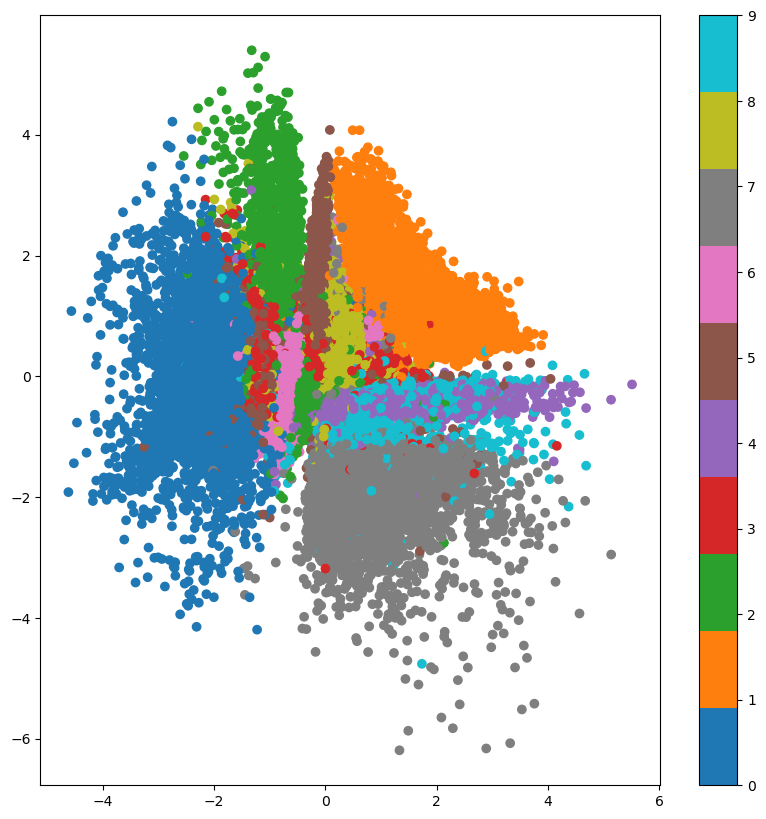

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

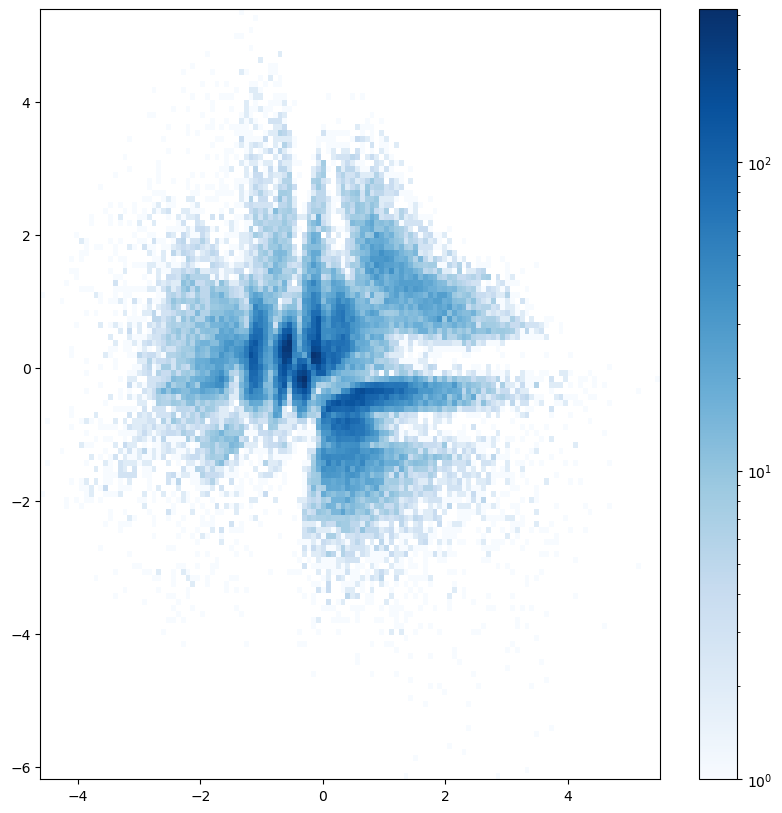

In [17]:

# plot as 2d histogram, log scale
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap='Blues', norm=LogNorm())
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_hist.webp')